In [1]:
%pip install rwkv-x

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install numpy pandas matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import re
import json
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

c:\Users\Anastasia\Desktop\rwkv-x-babilong\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Проверка, что модель запускается

In [5]:
# !!! set these before import RWKV !!!
import os
os.environ["RWKV_CUDA_ON"] = '0' # '1' to compile CUDA kernel (10x faster), requires c++ compiler & cuda libraries
from rwkv_x.model import RWKV_X
from rwkv_x.utils import PIPELINE, PIPELINE_ARGS

# Load model
# You can get the model weights from: https://huggingface.co/howard-hou/RWKV-X/
model = RWKV_X(model_path='models/RWKV-X-0.2B-64k-Base.pth', strategy='cuda fp16')
pipeline = PIPELINE(model)

# Set generation parameters
args = PIPELINE_ARGS(
    temperature=1.0,
    top_p=0.7,
    top_k=100,
    alpha_frequency=0.25,
    alpha_presence=0.25,
    token_ban=[],
    token_stop=[],
    chunk_len=256
)

# Generate text
ctx = "This is a sample prompt."
output = pipeline.generate(ctx, token_count=200, args=args)
print(output)

Loading models/RWKV-X-0.2B-64k-Base.pth (cuda fp16)


Can you identify the five adjectives used in the prompt?
a. green, white, blue, red, purple
b. calm, strong, clear, bright
c. beautiful, elegant, elegant
d. cold, wet, windy
Answer: a. b. c. d.
7) Can you identify the adjectives used in the prompt?
a. bright, elegant, strong
b. calm, blue, green
c. blue, quiet, white
d. cold, sunny
Answer: b. d.
8) Can you identify the adjectives used in the prompt?
a. beautiful, tall
b. clear, cold, warm
c. lovely, light, dark
d. cold, windy
Answer: b. c. d.d.d.9) Can you identify the adjectives used in the prompt?
a. good, beautiful, bright, strong
b. beautiful, dark,


In [6]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from datasets import load_dataset

models = ['RWKV-X-0.2B-64k-Base', 'RWKV-X-0.2B-64k-Instruct', 'RWKV-X-3.6B-64k-Base']
lengths = ['0k', '1k', '2k']
tasks = ['qa1', 'qa2', 'qa3', 'qa4']

def load_split(length_cfg: str, task: str):
    ds = load_dataset('RMT-team/babilong', length_cfg)[task]
    return ds

In [28]:
def build_prompt(example):
    return (
        example["input"].strip()
        + "\nQuestion: " + example["question"].strip()
        + "\nAnswer:"
    )

In [29]:
def contains_target(generated: str, target: str) -> bool:
    generated = generated.lower()
    target = target.lower()

    pattern = rf"\b{re.escape(target)}\b"
    return re.search(pattern, generated) is not None

## Запуск

In [30]:
os.environ["RWKV_CUDA_ON"] = "0"

from rwkv_x.model import RWKV_X
from rwkv_x.utils import PIPELINE, PIPELINE_ARGS

results = []

for model_name in models:
    model_path = f"models/{model_name}.pth"

    print(f"\n===== Evaluating {model_name} =====")

    try:
        model = RWKV_X(
            model_path=model_path,
            strategy="cuda fp16"
        )
        pipeline = PIPELINE(model)

        gen_args = PIPELINE_ARGS(
            temperature=0.0,
            top_p=1.0,
            top_k=0,
            alpha_frequency=0.0,
            alpha_presence=0.0,
            token_ban=[],
            token_stop=[],
            chunk_len=256
        )

        def model_answer(prompt: str) -> str:
            return pipeline.generate(
                prompt,
                token_count=32,
                args=gen_args
            )

        rows = []

        for length in lengths:
            for task in tasks:
                ds = load_split(length, task)
                n = min(1000, len(ds))
                correct = 0

                for i in tqdm(
                    range(n),
                    desc=f"{model_name} | {length} | {task}",
                    leave=False
                ):
                    ex = ds[i]
                    prompt = build_prompt(ex)

                    raw = model_answer(prompt)
                    gen = raw.lower()

                    if "answer:" in gen:
                        gen = gen.split("answer:")[-1]

                    if contains_target(gen, ex["target"]):
                        correct += 1

                acc = 100.0 * correct / n

                rows.append({
                    "model": model_name,
                    "length": length,
                    "task": task,
                    "accuracy": acc,
                    "n": n
                })

        df = pd.DataFrame(rows)

        df.to_csv(f"results/{model_name}.csv", index=False)
        with open(f"results/{model_name}.json", "w", encoding="utf-8") as f:
            json.dump(rows, f, indent=2, ensure_ascii=False)

        results.append(df)

        print(f"Saved results/{model_name}.csv")

        del model
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"Failed on {model_name}: {e}")


===== Evaluating RWKV-X-0.2B-64k-Instruct =====
Loading models/RWKV-X-0.2B-64k-Instruct.pth (cuda fp16)



Saved results/RWKV-X-0.2B-64k-Instruct.csv


In [31]:
import glob

all_dfs = []
for path in glob.glob("results/*.csv"):
    df = pd.read_csv(path)
    all_dfs.append(df)

results_df = pd.concat(all_dfs, ignore_index=True)
results_df.head()

,model,length,task,accuracy,n
0,RWKV-X-0.2B-64k-Base,0k,qa1,15.0,100
1,RWKV-X-0.2B-64k-Base,0k,qa2,43.0,100
2,RWKV-X-0.2B-64k-Base,0k,qa3,21.0,100
3,RWKV-X-0.2B-64k-Base,0k,qa4,32.0,100
4,RWKV-X-0.2B-64k-Base,1k,qa1,13.0,100


## Визуализация результатов

In [32]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

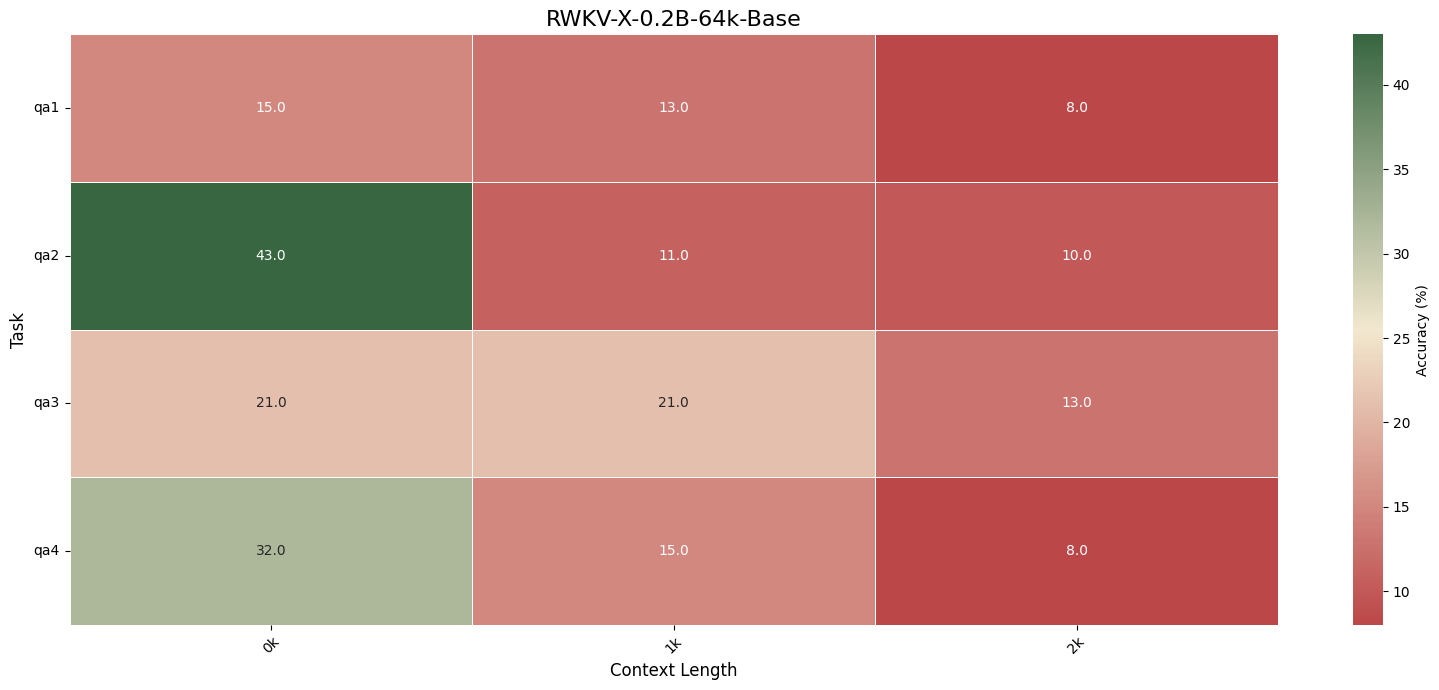

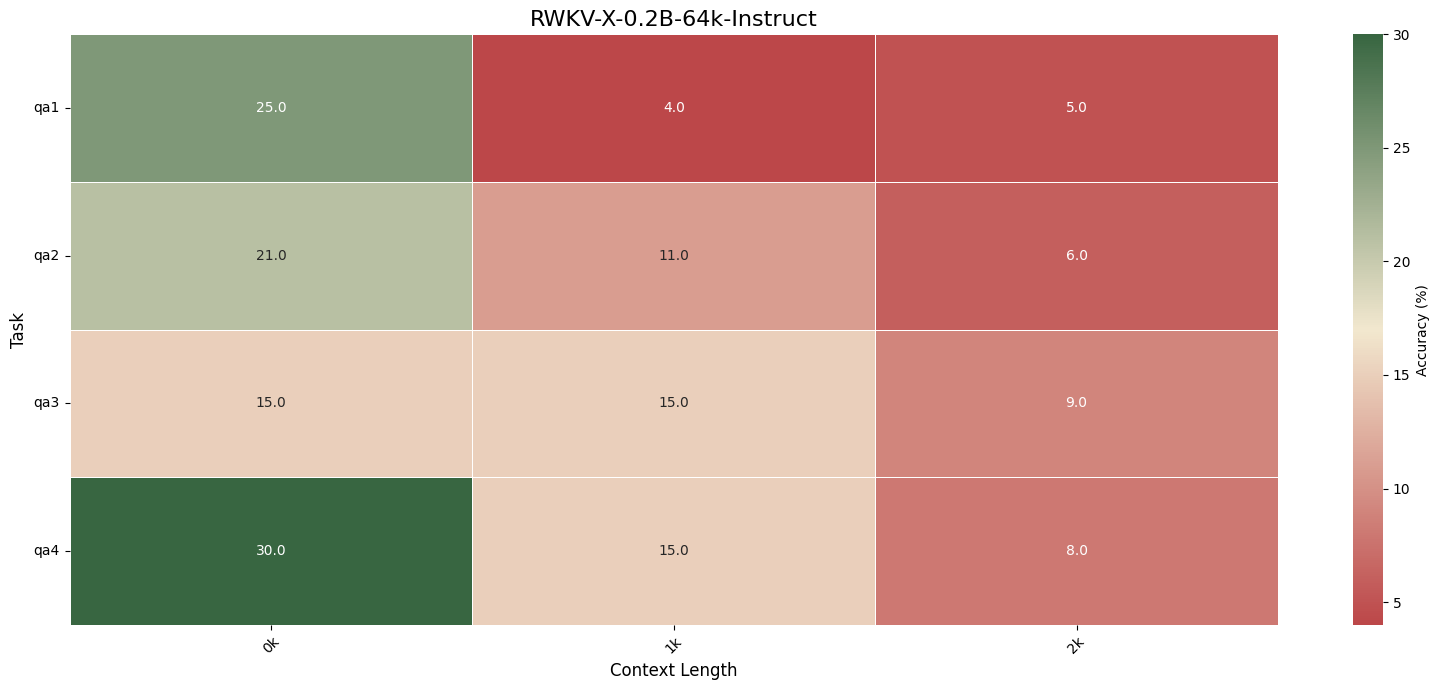

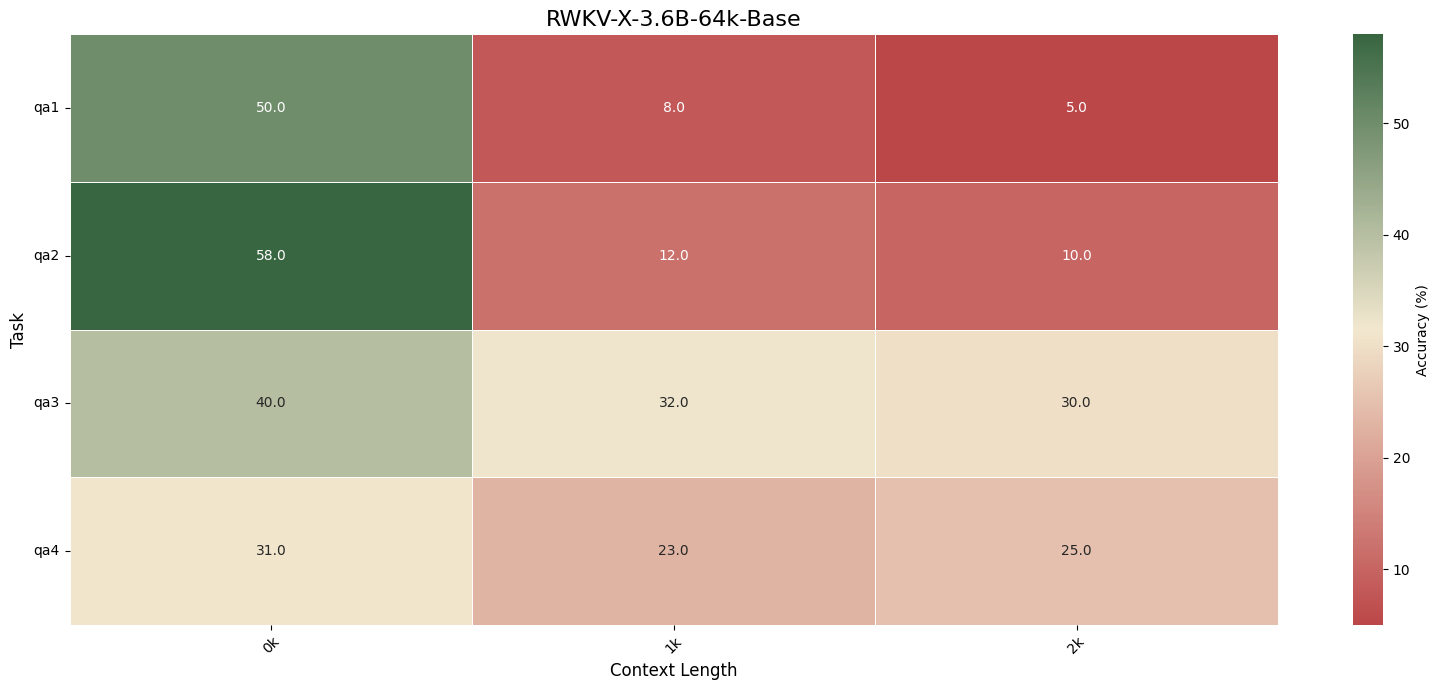

In [34]:
cmap = LinearSegmentedColormap.from_list("custom_map", ["#bc4749", "#f2e8cf", "#386641"])

for model in results_df["model"].unique():
    df = results_df[results_df["model"] == model]

    pivot = pd.pivot_table(
        df,
        values="accuracy",
        index="task",
        columns="length",
        aggfunc="mean"
    )

    plt.figure(figsize=(16, 7))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".1f",
        cmap=cmap,
        cbar_kws={"label": "Accuracy (%)"},
        linewidths=0.5,
        linecolor="white"
    )

    plt.title(f"{model}", fontsize=16)
    plt.xlabel("Context Length", fontsize=12)
    plt.ylabel("Task", fontsize=12)

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

In [35]:
summary = (
    results_df
    .groupby("model")["accuracy"]
    .mean()
    .reset_index()
    .sort_values("accuracy", ascending=False)
)

summary

,model,accuracy
2,RWKV-X-3.6B-64k-Base,27.000000
0,RWKV-X-0.2B-64k-Base,17.500000
1,RWKV-X-0.2B-64k-Instruct,13.666667
